Acknowledgement:

This part of the model was inspired by [1].

[1] B. Wang and J. Vastola, “ML from scratch: Stable Diffusion,” 2022. [Online]. Available: https://doi.org/10.5281/zenodo.14716399

# Choose the cardiac phase that you train Mesh LDM for

In [ ]:
cardiac_phase = "ED"
# cardiac_phase = "ES"

In [ ]:
if cardiac_phase == "ED":
    encoded_output_dir = "/home/vaen/Desktop/MeshLDM_publication/data/encoded/encoded_only_ED_16"
    denoised_output_dir = "/home/vaen/Desktop/MeshLDM_publication/data/denoised/ED"

elif cardiac_phase == "ES":
    encoded_output_dir = "/home/vaen/Desktop/MeshLDM_publication/data/encoded/encoded_only_ES_16"
    denoised_output_dir = "/home/vaen/Desktop/MeshLDM_publication/data/denoised/ES"

# Imports and configs

In [ ]:
import os
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import diffusers
from diffusers import DDPMScheduler

In [ ]:
if cardiac_phase == "ED":
    # ED mean and std
    train_data_mean = torch.tensor([-0.0086,  2.5938,  0.0278,  3.4601,  3.2333,  3.3586,  0.0415,  0.0328,
         2.4860, -0.0790, -0.0303,  0.0653,  3.4665,  3.2370,  0.0225, -0.0159]).to(device)

    train_data_std = torch.tensor([0.9634, 2.6815, 1.0325, 3.3553, 3.2094, 3.3775, 1.0034, 0.9920, 2.7689,
        1.0292, 1.0005, 1.0040, 3.3220, 3.5437, 0.9682, 1.0255]).to(device)


elif cardiac_phase == "ES":
    # ES mean and std
    train_data_mean = torch.tensor([-0.0494,  1.5750,  2.2315,  1.8140,  1.8572, -0.0514,  1.7915,  1.8904,
         1.9286, -0.0092,  1.6116,  1.9383,  2.1109,  1.9209,  1.9336,  2.0033]).to(device)
    train_data_std = torch.tensor([1.0329, 2.0033, 2.9584, 3.1641, 2.2091, 0.9602, 2.8612, 2.6477, 2.9608,
        0.9766, 2.1016, 2.5876, 2.2940, 2.5560, 2.0430, 2.4994]).to(device)

# Time embedding - helper functions


The following code enables our neural network to incorporate temporal information through a time embedding. Rather than providing the network with a single scalar representing the current time, we express the time using a variety of sinusoidal features. The idea is that by presenting the current time in multiple forms, the network can more effectively adapt to temporal changes. This approach allows us to learn a time-dependent score function $s(x, t)$ successfully.

In [ ]:
class GaussianFourierProjection(nn.Module):
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    # slicing with None adds dimension to the array
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)

# Denoising model

In [ ]:
class FCN(nn.Module):
  """A time-dependent score-based model built upon fully connected architecture."""
  def __init__(self,
               embed_dim=16, dims=[16, 16, 16, 16]):
    """
    Args:
      embed_dim: Dimensions of Gaussian random feature embeddings.
      dims: Dimensions of FCN layers.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )

    self.dense1 = Dense(embed_dim, dims[1])
    self.dense2 = Dense(embed_dim, dims[2])
    self.dense3 = Dense(embed_dim, dims[3])

    self.linear1 = nn.Linear(dims[0], dims[1])
    self.linear2 = nn.Linear(dims[1], dims[2])
    self.linear3 = nn.Linear(dims[2], dims[3])
    self.linear4 = nn.Linear(dims[3], dims[2])
    self.linear5 = nn.Linear(dims[2], dims[1])
    self.linear6 = nn.Linear(dims[1], dims[0])

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)


  def forward(self, x, t, y=None):
    embed = self.act(self.time_embed(t))

    h1 = self.act(self.linear1(x) + self.dense1(embed))
    h2 = self.act(self.linear2(h1) + self.dense2(embed))
    h3 = self.act(self.linear3(h2) + self.dense3(embed))
    h4 = self.act(self.linear4(h3) + self.dense2(embed))
    h5 = self.act(self.linear5(h4) + self.dense1(embed))
    h6 = self.linear6(h5)

    return h6

# Loss function

In [ ]:
def loss_fn(model, x, beta_scheduler, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    beta_scheduler: A noise scheduler, e.g. chosen from Diffusers library.
    eps: A tolerance value for numerical stability.
  """
  max_t = 1000
  random_t = torch.randint(0, max_t, (x.shape[0],), device=x.device)
  noise = torch.randn(x.shape, device=x.device)
  perturbed_x = beta_scheduler.add_noise(x, noise, random_t)
  model_output = model(perturbed_x, random_t)
  loss = F.mse_loss(model_output, noise)

  return loss

# Scheduler

In [ ]:
beta_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Sampler

In [ ]:
# Function used only for generating results after training
def ddpm_sampler(
              score_model,
              beta_scheduler,
              batch_size=64,
              x_shape=(16,),
              num_steps=500,
              device='cuda',
              y=None):
  """Generate samples from score-based model.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    beta_scheduler: A scheduler chosen from diffusers library for adding/removing noise during diffusion process.
    batch_size: The number of samplers to generate by calling this function once.
    x_shape: The shape of the samples to generate.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.

  Returns:
    Samples.
  """

  print("Sampling from N(0, 1)")
  x = torch.randn(batch_size, *x_shape, device=device)
  # print("x.shape: ", x.shape)
  # print("dtype: ", x.dtype)

  with torch.no_grad():
    for t in beta_scheduler.timesteps:
      batch_time_step = torch.ones(batch_size, device=device) * t
      # 1. predict noise model_output
      model_output = score_model(x, batch_time_step, y=y)
      print("model_output.shape: ", model_output.shape)
      # 2. compute previous image: x_t -> x_t-1
      x = beta_scheduler.step(model_output, t, x).prev_sample

  # Do not include any noise in the last sampling step.
  return x

# Load Data

In [ ]:
with open(encoded_output_dir + '/train/z_data.npy', 'rb') as f:
    z_data_train = torch.tensor(np.load(f))

with open(encoded_output_dir + '/train/y_data.npy', 'rb') as f:
    y_data_train = torch.tensor(np.load(f))

In [ ]:
print("z_data_train.shape: ", z_data_train.shape)
print("y_data_train.shape: ", y_data_train.shape)

z_data_train.shape:  torch.Size([693, 1, 16])
y_data_train.shape:  torch.Size([693, 2450, 3])


In [ ]:
z_data_train = torch.flatten(z_data_train, start_dim=1).to(device)
print(z_data_train.shape)

torch.Size([693, 16])


# Normalise data

In [ ]:
# 1st vector before normalising
z_data_train[0]

tensor([ 3.8485e-01,  4.5584e+00,  7.2971e-02,  2.1920e-01, -2.2405e-01,
         8.0838e+00, -3.8336e-02,  8.4927e-01,  2.4061e+00,  3.4594e-01,
         6.8657e-01,  7.3485e-03,  3.5259e+00,  3.7157e+00, -1.5930e-01,
         1.6780e-01])

In [ ]:
z_data_train = (z_data_train - train_data_mean) / train_data_std

In [ ]:
# 1st vector after normalising
z_data_train[0]

tensor([ 0.4084,  0.7327,  0.0437, -0.9659, -1.0773,  1.3990, -0.0796,  0.8230,
        -0.0289,  0.4129,  0.7165, -0.0577,  0.0179,  0.1351, -0.1878,  0.1791])

In [ ]:
print("z_data_train.shape: ", z_data_train.shape)

z_data_train.shape:  torch.Size([693, 16])


# Training

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
latent_dataset = TensorDataset(z_data_train, y_data_train)
latent_score_model = torch.nn.DataParallel(FCN(embed_dim=16, dims=[16, 16, 16, 16]))

latent_score_model = latent_score_model.to(device)

# n_epochs = 600
n_epochs = 1600
batch_size = 64
lr=5e-3

latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True,)
latent_score_model.train()

optimizer = Adam(latent_score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)

use_lambda_lr = True

if use_lambda_lr:
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch:
                         max(0.5, 0.995 ** epoch))



  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
print("start training")
losses = []
epoch_counter = 0
for epoch in tqdm_epoch:
  epoch_counter += 1
  if epoch_counter % 10 == 0:
    print("epoch: ", epoch_counter)
  avg_loss = 0.
  num_items = 0
  data_loader_cnt = 0
  for z, y in latent_data_loader:
    z = z.to(device)
    data_loader_cnt += 1
    loss = loss_fn(latent_score_model, z, beta_scheduler)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * z.shape[0]
    num_items += z.shape[0]

  if use_lambda_lr:
    lr_scheduler.step()
    lr_current = lr_scheduler.get_last_lr()[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f} lr {:.1e}'.
                             format(avg_loss / num_items, lr_current))
  losses.append(avg_loss / num_items)
  # Update the checkpoint after each epoch of training.
  torch.save(latent_score_model.state_dict(), 'ckpt_ldm_fcn_no_lr_scheduler.pth')

start training
epoch:  10
epoch:  20
epoch:  30
epoch:  40
epoch:  50
epoch:  60
epoch:  70
epoch:  80
epoch:  90
epoch:  100
epoch:  110
epoch:  120
epoch:  130
epoch:  140
epoch:  150
epoch:  160
epoch:  170
epoch:  180
epoch:  190
epoch:  200
epoch:  210
epoch:  220
epoch:  230
epoch:  240
epoch:  250
epoch:  260
epoch:  270
epoch:  280
epoch:  290
epoch:  300
epoch:  310
epoch:  320
epoch:  330
epoch:  340
epoch:  350
epoch:  360
epoch:  370
epoch:  380
epoch:  390
epoch:  400
epoch:  410
epoch:  420
epoch:  430
epoch:  440
epoch:  450
epoch:  460
epoch:  470
epoch:  480
epoch:  490
epoch:  500
epoch:  510
epoch:  520
epoch:  530
epoch:  540
epoch:  550
epoch:  560
epoch:  570
epoch:  580
epoch:  590
epoch:  600
epoch:  610
epoch:  620
epoch:  630
epoch:  640
epoch:  650
epoch:  660
epoch:  670
epoch:  680
epoch:  690
epoch:  700
epoch:  710
epoch:  720
epoch:  730
epoch:  740
epoch:  750
epoch:  760
epoch:  770
epoch:  780
epoch:  790
epoch:  800
epoch:  810
epoch:  820
epoch:  83

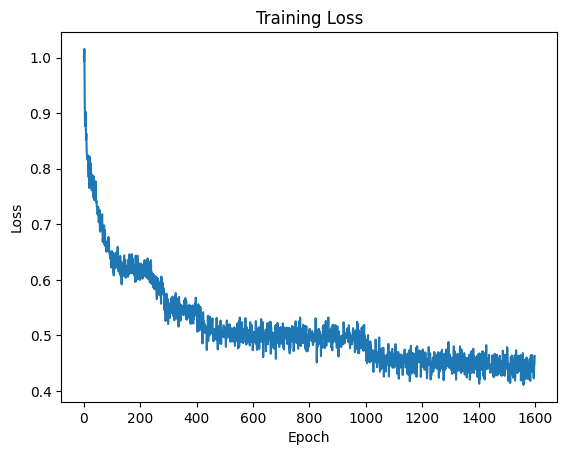

In [ ]:
# Graph the training loss.
xs = np.arange(len(losses))
plt.plot(xs, losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Generate samples

In [ ]:
def save_samples_uncond(latent_score_model, suffix=""):
  latent_score_model.eval()
  sample_batch_size = 1000
  num_steps = 250
  sampler = ddpm_sampler
  ## Generate samples using the specified sampler.
  samples_z = sampler(latent_score_model,
                      beta_scheduler,
                      sample_batch_size,
                      x_shape=(16,),
                      num_steps=num_steps,
                      device=device,
                      y=None)


  ## Denormalise the data
  samples_z = samples_z * train_data_std + train_data_mean

  if not os.path.exists(denoised_output_dir):
      os.makedirs(denoised_output_dir)

  with open(denoised_output_dir + '/samples.npy', 'wb') as f:
    np.save(f, samples_z.cpu().numpy())

  print(samples_z)

In [ ]:
save_samples_uncond(latent_score_model, suffix="_res")

Sampling from N(0, 1)
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_output.shape:  torch.Size([1000, 16])
model_outp